In [10]:
import matplotlib.pyplot as plt

# wrappers.py

In [1]:
import jax
import jax.numpy as jnp
import chex
import numpy as np
from flax import struct
from functools import partial
from typing import Optional, Tuple, Union, Any
from gymnax.environments import environment, spaces
from brax import envs
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper


class GymnaxWrapper(object):
    """Base class for Gymnax wrappers."""

    def __init__(self, env):
        self._env = env

    # provide proxy access to regular attributes of wrapped object
    def __getattr__(self, name):
        return getattr(self._env, name)


class FlattenObservationWrapper(GymnaxWrapper):
    """Flatten the observations of the environment."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    def observation_space(self, params) -> spaces.Box:
        assert isinstance(
            self._env.observation_space(params), spaces.Box
        ), "Only Box spaces are supported for now."
        return spaces.Box(
            low=self._env.observation_space(params).low,
            high=self._env.observation_space(params).high,
            shape=(np.prod(self._env.observation_space(params).shape),),
            dtype=self._env.observation_space(params).dtype,
        )

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, state = self._env.reset(key, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state, reward, done, info


@struct.dataclass
class LogEnvState:
    env_state: environment.EnvState
    episode_returns: float
    episode_lengths: int
    returned_episode_returns: float
    returned_episode_lengths: int
    timestep: int


class LogWrapper(GymnaxWrapper):
    """Log the episode returns and lengths."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, env_state = self._env.reset(key, params)
        state = LogEnvState(env_state, 0, 0, 0, 0, 0)
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )
        new_episode_return = state.episode_returns + reward
        new_episode_length = state.episode_lengths + 1
        state = LogEnvState(
            env_state=env_state,
            episode_returns=new_episode_return * (1 - done),
            episode_lengths=new_episode_length * (1 - done),
            returned_episode_returns=state.returned_episode_returns * (1 - done)
            + new_episode_return * done,
            returned_episode_lengths=state.returned_episode_lengths * (1 - done)
            + new_episode_length * done,
            timestep=state.timestep + 1,
        )
        info["returned_episode_returns"] = state.returned_episode_returns
        info["returned_episode_lengths"] = state.returned_episode_lengths
        info["timestep"] = state.timestep
        info["returned_episode"] = done
        return obs, state, reward, done, info


class BraxGymnaxWrapper:
    def __init__(self, env_name, backend="positional"):
        env = envs.get_environment(env_name=env_name, backend=backend)
        env = EpisodeWrapper(env, episode_length=1000, action_repeat=1)
        env = AutoResetWrapper(env)
        self._env = env
        self.action_size = env.action_size
        self.observation_size = (env.observation_size,)

    def reset(self, key, params=None):
        state = self._env.reset(key)
        return state.obs, state

    def step(self, key, state, action, params=None):
        next_state = self._env.step(state, action)
        return next_state.obs, next_state, next_state.reward, next_state.done > 0.5, {}

    def observation_space(self, params):
        return spaces.Box(
            low=-jnp.inf,
            high=jnp.inf,
            shape=(self._env.observation_size,),
        )

    def action_space(self, params):
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self._env.action_size,),
        )


class ClipAction(GymnaxWrapper):
    def __init__(self, env, low=-1.0, high=1.0):
        super().__init__(env)
        self.low = low
        self.high = high

    def step(self, key, state, action, params=None):
        """TODO: In theory the below line should be the way to do this."""
        # action = jnp.clip(action, self.env.action_space.low, self.env.action_space.high)
        action = jnp.clip(action, self.low, self.high)
        return self._env.step(key, state, action, params)


class TransformObservation(GymnaxWrapper):
    def __init__(self, env, transform_obs):
        super().__init__(env)
        self.transform_obs = transform_obs

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        return self.transform_obs(obs), state

    def step(self, key, state, action, params=None):
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        return self.transform_obs(obs), state, reward, done, info


class TransformReward(GymnaxWrapper):
    def __init__(self, env, transform_reward):
        super().__init__(env)
        self.transform_reward = transform_reward

    def step(self, key, state, action, params=None):
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        return obs, state, self.transform_reward(reward), done, info


class VecEnv(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.reset = jax.vmap(self._env.reset, in_axes=(0, None))
        self.step = jax.vmap(self._env.step, in_axes=(0, 0, 0, None))


@struct.dataclass
class NormalizeVecObsEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    env_state: environment.EnvState


class NormalizeVecObservation(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        state = NormalizeVecObsEnvState(
            mean=jnp.zeros_like(obs),
            var=jnp.ones_like(obs),
            count=1e-4,
            env_state=state,
        )
        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=state.env_state,
        )

        return (obs - state.mean) / jnp.sqrt(state.var + 1e-8), state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )

        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=env_state,
        )
        return (
            (obs - state.mean) / jnp.sqrt(state.var + 1e-8),
            state,
            reward,
            done,
            info,
        )


@struct.dataclass
class NormalizeVecRewEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    return_val: float
    env_state: environment.EnvState


class NormalizeVecReward(GymnaxWrapper):
    def __init__(self, env, gamma):
        super().__init__(env)
        self.gamma = gamma

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        batch_count = obs.shape[0]
        state = NormalizeVecRewEnvState(
            mean=0.0,
            var=1.0,
            count=1e-4,
            return_val=jnp.zeros((batch_count,)),
            env_state=state,
        )
        return obs, state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )
        return_val = state.return_val * self.gamma * (1 - done) + reward

        batch_mean = jnp.mean(return_val, axis=0)
        batch_var = jnp.var(return_val, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecRewEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            return_val=return_val,
            env_state=env_state,
        )
        return obs, state, reward / jnp.sqrt(state.var + 1e-8), done, info        

# Slightly modified PPO

In [11]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax


class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).n, activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                # Batching and Shuffling
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                # Mini-batch Updates
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss
            # Updating Training State and Metrics:
            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            
            # Debugging mode
            # if config.get("DEBUG"):
            #     def callback(info):
            #         return_values = info["returned_episode_returns"][info["returned_episode"]]
            #         timesteps = info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
            #         for t in range(len(timesteps)):
            #             print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
            #     jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 2.5e-4,
        "NUM_ENVS": 4,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ENV_NAME": "CartPole-v1",
        "ANNEAL_LR": True,
        "DEBUG": True,
    }
    rng = jax.random.PRNGKey(30)
    train_jit = jax.jit(make_train(config))
    out = train_jit(rng)

In [17]:
from jax.random import split
out = jax.vmap(train_jit)(split(rng, 32))

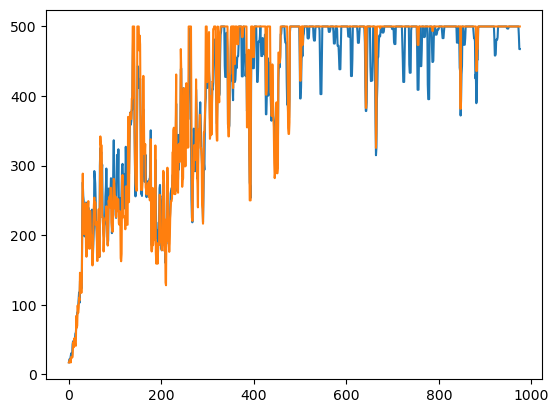

In [16]:
plt.plot(jnp.mean(out['metrics']['returned_episode_returns'], axis=(-1, -2)))
plt.plot(jnp.median(out['metrics']['returned_episode_returns'], axis=(-1, -2)))

